# Séparation de sources

In [196]:
from __future__ import division
from IPython.display import Audio
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import pywt
import scipy.io as sio
from scipy import fftpack
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import wave
import warnings
from scipy.io.wavfile import read
warnings.filterwarnings('ignore')

Le but de ce TP est de réaliser un programme python qui effectue une séparation de sources. Plus précisément un programme qui prend en entrée un son stéréophonique, mélange instantané de plusieurs sources sonores (ici des instruments de musique) et qui renvoie plusieurs sons stéréophoniques. On utilisera la transformée de Fourier à court terme (TFCT), ou transformée de Fourier à fenêtres, vue lors du TP précédent. 
    Le procédé général de ce programme de séparation de sources est intégralement décrit dans le poly de cours. Je vous invite à vous y reporter pour de plus amples explications. En bref, on va utiliser le fait, 
    que la plupart du temps, deux instrusments ne jouent pas la même note au même moment et on va segmenter les spectrogrammes des deux voix de manière à attribuer chaque atome temps-fréquence à un instrument, en fonction du rapport d'intensité entre les deux voix, qui est supposé caractérisé chaque instrument.
Le TP de décompose en trois parties.

1) On considère un mélange de seulement deux instruments et on fait l'hypothèse que l'on connait les coefficients du mélange.

2) On considère un mélange de trois instruments et on fait l'hypothèse que l'on connait les coefficients du mélange.

3) On considère le même mélange de trois instruments mais cette fois ci on estime les coefficients de mélange.

Ce TP s'appuiera sur les codes réalisés lors du précédent, plus précisément TFCourtTerme et RecSon.

On installe maintenant les code des TP précédents.

In [197]:
def TFCourtTerme(Son,N=1024,rec=8):
    H=np.hanning(N)
    NS=len(Son)
    Nf=int(np.floor(rec*NS/N)-rec+1)
    TF=np.zeros((N,Nf),dtype=complex)
    for k in range(0,Nf):
        d=int(k*N/rec)
        f=d+N
        TF[:,k]=fftpack.fft(Son[d:f]*H)
    return TF

In [198]:
def RecSon(TF,rec=8):
    N=np.shape(TF)[0]
    Nf=np.shape(TF)[1]
    H=np.hanning(N)
    Son=np.zeros(N*(Nf+rec-1)//rec)
    for k in range(0,Nf):
        d=int(k*N)//rec
        f=d+N
        Son[d:f]=Son[d:f]+H*np.real(fftpack.ifft(TF[:,k]))
    Son=Son/np.log2(rec)
    return Son

## Séparation de deux instruments

A l'aide la fonction read, charger dans deux vecteurs différents $V1$ et $V2$ les sons Mix11.wav et Mix21.wav et afficher les tranformées de Fourier à fenêtres de chacune des deux voix (on utilisera TFCourtTerme).
On pourra afficher les basses fréquences pour mieux voir.
On fait l'hypothèse que les voix 1 et 2 (dites V1 et V2 ) est obtenue à partir des deux sources S1 et S2 de la manière suivante :
$$V_1=\frac{1}{3}S_1+\frac{2}{3}S_2\text{ et }V_2=\frac{2}{3}S_1+\frac{1}{3}S_2$$
Vous devriez voir les traces des deux instruments qui diffèrent par leur structure.

On va maintenant charger les fichiers

In [199]:
V1 = read("./2 instruments/Mix11.wav")
V2 = read("./2 instruments/Mix21.wav")
TFCT1=TFCourtTerme(V1[1])
TFCT2=TFCourtTerme(V2[1])

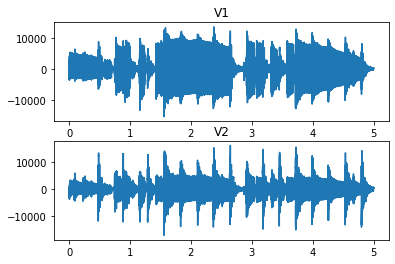

In [200]:
t=np.linspace(0,len(V1[1])/V1[0],len(V1[1]))
f, axarr = plt.subplots(2)
axarr[0].plot(t,V1[1])
axarr[0].set_title("V1")
axarr[1].plot(t,V2[1])
axarr[1].set_title("V2")
plt.show()

In [201]:
Audio(V1[1],rate=V1[0])

In [202]:
Audio(V2[1],rate=V2[0])

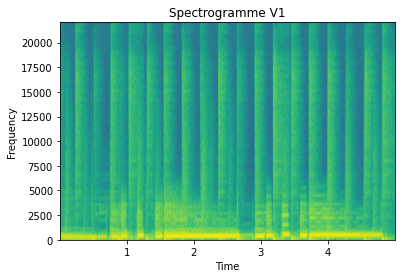

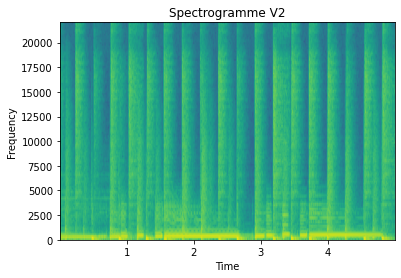

In [203]:
# les spectrogramme à l'aide du fonction specgram
plt.figure("SpecV1")
plt.specgram(V1[1],Fs=V1[0])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogramme V1')
plt.show()

plt.figure("SpecV1")
plt.specgram(V2[1],Fs=V2[0])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogramme V2')
plt.show()

Le spectrogramme totale ne montre pas des informations nécessaires, donc il faut faire le spectrogramme de basse fréquence.

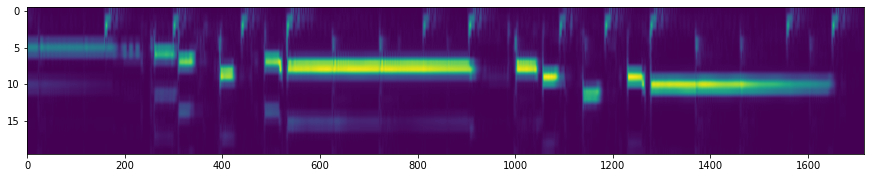

In [204]:
plt.figure(figsize = (15,10))
plt.imshow(np.abs(TFCT1)[0:20,:], aspect = 15)
plt.show()

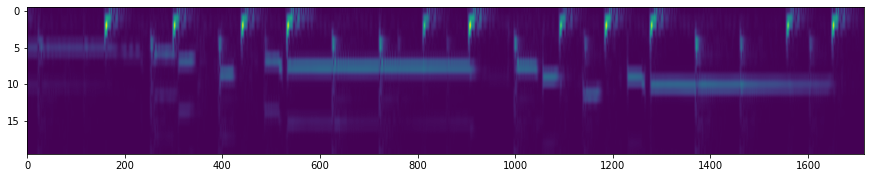

In [205]:
plt.figure(figsize = (15,10))
plt.imshow(np.abs(TFCT2)[0:20,:], aspect = 15)
plt.show()

Proposer un programme Separation2Instru qui prend en entrée deux Transformées de Fourier à court terme (TFCT) et un seuil $T$ et qui renvoie 4 TFCT, chacune associée à une source et à un instrument. Le détail de la procédure est décrite dans le poly et a été expliqué en cours. On rappelle, qu'on effectue la séparation uniquement à partir du module de la TFCT. On reconstruit ensuite les TFCT en utilisant les phases des voix 1 et 2.

In [206]:
def Separation2Instru(TFCT1,TFCT2,T):
    TF2=np.zeros(TFCT1.shape,dtype=complex)
    TF1=np.zeros(TFCT1.shape,dtype=complex)
    TF3=np.zeros(TFCT1.shape,dtype=complex)
    TF4=np.zeros(TFCT1.shape,dtype=complex)

    TF1[:,:] = TFCT1[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])<T)
    TF2[:,:] = TFCT2[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])<T)
    TF3[:,:] = TFCT1[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])>=T)
    TF4[:,:] = TFCT2[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])>=T)
    
    return (TF1,TF2,TF3,TF4)

Quel seuil peut-on proposer ici ? Proposer une formule générale en fonction des coefficients du mélange.

On propose ici une seuil $T=1$. Plus général, on considère $R1$ et $R2$ sont des rapports des coefficients des instruments $V1$ et $V2$, on a alors la seuil : $T=\sqrt{R1.R2}$.

In [207]:
R1 = (1/3)/(2/3)
R2 = (2/3)/(1/3)
T = np.sqrt(R1*R2)

Reconstruire ensuite à l'aide du programme RecSon, chacune des voix et écouter chacun des 4 sons produits. 
Commentez le résultat.

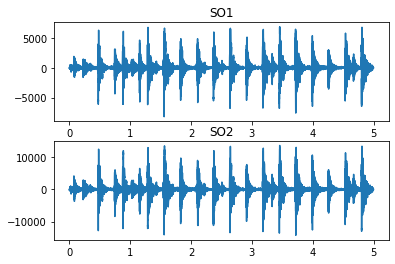

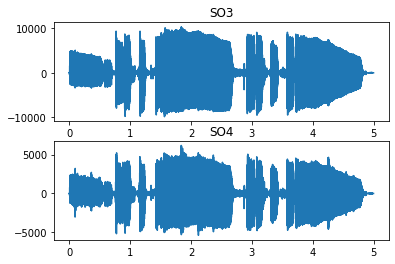

In [208]:
#
SO1,SO2,SO3,SO4=Separation2Instru(TFCT1,TFCT2,T)
#
RS1 = RecSon(SO1)
RS2 = RecSon(SO2)
RS3 = RecSon(SO3)
RS4 = RecSon(SO4)
#
t=np.linspace(0,len(RS1)/V1[0],len(RS1))

f, axarr = plt.subplots(2)
axarr[0].plot(t,RS1)
axarr[0].set_title("SO1")
axarr[1].plot(t,RS2)
axarr[1].set_title("SO2")
plt.show()
f2, axarr2 = plt.subplots(2)
axarr2[0].plot(t,RS3)
axarr2[0].set_title("SO3")
axarr2[1].plot(t,RS4)
axarr2[1].set_title("SO4")
plt.show()


In [209]:
Audio(RS1,rate=V1[0])

In [210]:
Audio(RS2,rate=V2[0])

In [211]:
Audio(RS3,rate=V1[0])

In [212]:
Audio(RS4,rate=V2[0])

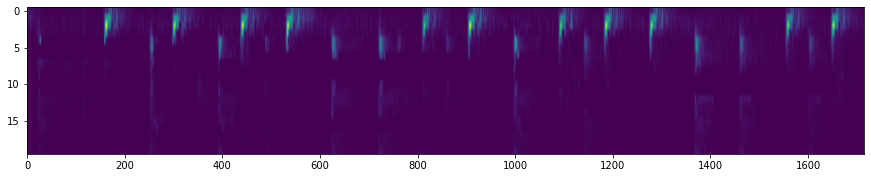

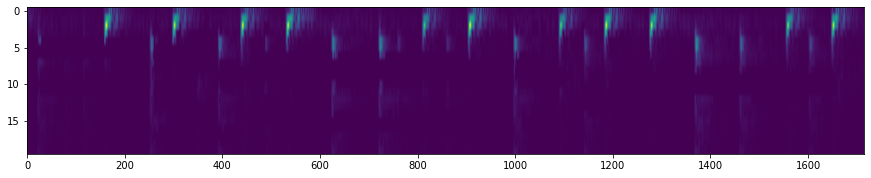

In [213]:
plt.figure(figsize = (15,10))
plt.imshow(np.abs(SO1)[0:20,:], aspect = 15)
plt.show()
plt.figure(figsize = (15,10))
plt.imshow(np.abs(SO2)[0:20,:], aspect = 15)
plt.show()

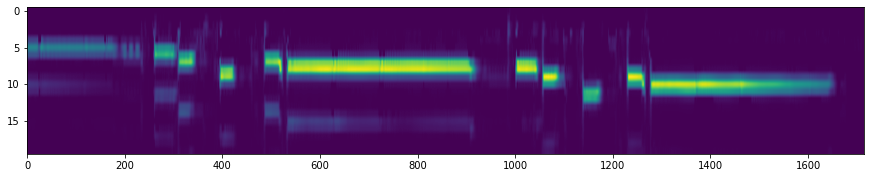

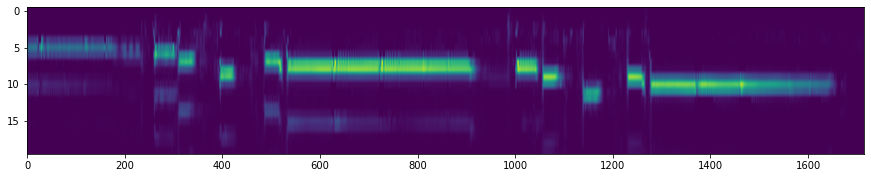

In [214]:
plt.figure(figsize = (15,10))
plt.imshow(np.abs(SO3)[0:20,:], aspect = 15)
plt.show()
plt.figure(figsize = (15,10))
plt.imshow(np.abs(SO4)[0:20,:], aspect = 15)
plt.show()

Commentaire : Cette méthode permet de reconstituer bien les signaux d’origine : on peut bien distinguer à l’oreille 2 enregistrements isolant des instruments. Cependant cela est valable lorsque l’on connait exactement les coefficients de chaque instrument dans la source. Sinon, on doit chercher la seuil $T$ pour que la méthode fonctionne et cela va prendre beaucoup d'effort.


## Séparation de trois instruments

Charger les nouvelles voix 1 et 2 à partir des fichiers Mix12.wav et Mix22.wav.
    On fait l'hypothèse que chacune des voix est maintenant un mélange instantané de trois instruments 
$$SV_1= \frac{2}{5}S_1 + \frac{1}{5}S_2 + \frac{4}{5}S_3\text{ et }V_2= \frac{3}{5}S_1 + \frac{4}{5}S_2 + \frac{1}{5}S_3$$


In [215]:
V1 = read("./3 instruments/Mix12.wav")
V2 = read("./3 instruments/Mix22.wav")
TFCT1=TFCourtTerme(V1[1])
TFCT2=TFCourtTerme(V2[1])

In [216]:
Audio(V1[1], rate = V1[0])

In [217]:
Audio(V2[1], rate = V2[0])

Afficher les spectrogrammes des deux voix et visualiser les traces des trois instruments. 

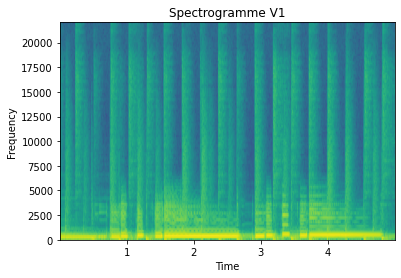

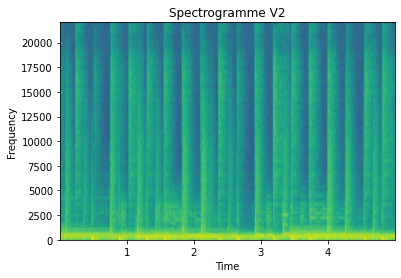

In [218]:
# les spectrogramme à l'aide du fonction specgram
plt.figure("SpecV1")
plt.specgram(V1[1],Fs=V1[0])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogramme V1')
plt.show()

plt.figure("SpecV1")
plt.specgram(V2[1],Fs=V2[0])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogramme V2')
plt.show()

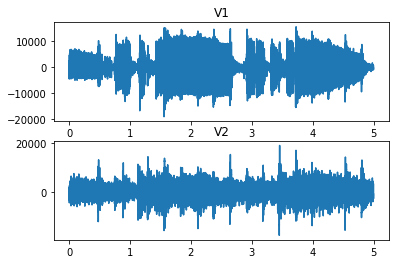

In [219]:
t=np.linspace(0,len(V1[1])/V1[0],len(V1[1]))
f, axarr = plt.subplots(2)
axarr[0].plot(t,V1[1])
axarr[0].set_title("V1")
axarr[1].plot(t,V2[1])
axarr[1].set_title("V2")
plt.show()

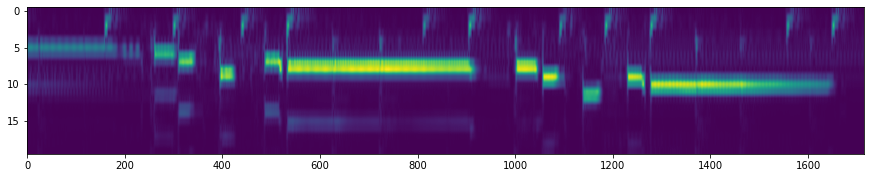

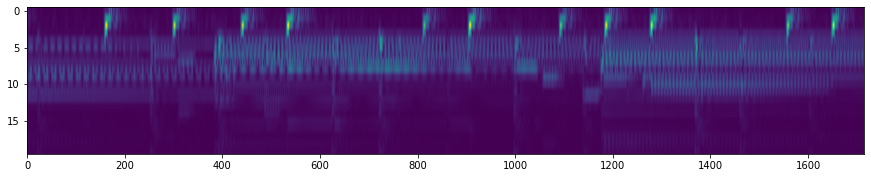

In [220]:
plt.figure(figsize = (15,10))
plt.imshow(np.abs(TFCT1)[0:20,:], aspect = 15)
plt.show()
plt.figure(figsize = (15,10))
plt.imshow(np.abs(TFCT2)[0:20,:], aspect = 15)
plt.show()

Proposer un programme de séparation Separation3Instru qui prend en entrée deux TFCT, un vecteur $T$ seuil à 2 composantes et qui renvoie 6 TFCT associées aux deux voix de chacun des trois instruments. 



In [221]:
def Separation3Instru(TFCT1,TFCT2,T):
    TF2=np.zeros(TFCT1.shape,dtype=complex)
    TF1=np.zeros(TFCT1.shape,dtype=complex)
    TF3=np.zeros(TFCT1.shape,dtype=complex)
    TF4=np.zeros(TFCT1.shape,dtype=complex)
    TF5=np.zeros(TFCT1.shape,dtype=complex)
    TF6=np.zeros(TFCT1.shape,dtype=complex)

    TF1[:,:] = TFCT1[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])<T[0])
    TF2[:,:] = TFCT2[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])<T[0])
    TF3[:,:] = TFCT1[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])>=T[0])*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])<T[1])
    TF4[:,:] = TFCT2[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])>=T[0])*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])<T[1])
    TF5[:,:] = TFCT1[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])>=T[1])
    TF6[:,:] = TFCT2[:,:]*(np.abs(TFCT1[:,:])/np.abs(TFCT2[:,:])>=T[1])

    
    return (TF1,TF2,TF3,TF4,TF5,TF6)

Ecrire un programme CalculSeuil qui prend en entrée 3 rapports d'intensité et qui renvoie deux seuils associés. 

In [222]:
def CalculSeuil(R):
    n = len(R)-1
    T = np.zeros(n)
    for i in range(n):
        T[i]=np.sqrt(R[i]*R[i+1])
    return T

Tester le programme en utilisant les rapports d'intensités calculés à partir des coefficients de mélange, et commenter.

In [227]:
R = np.array([2/3,1/4,4/1])
R = np.sort(R)
T = CalculSeuil(R)
print(T)
SO1,SO2,SO3,SO4,SO5,SO6 = Separation3Instru(TFCT1,TFCT2,T)

[0.40824829 1.63299316]


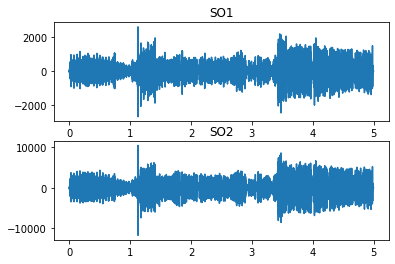

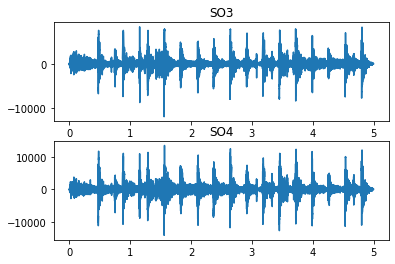

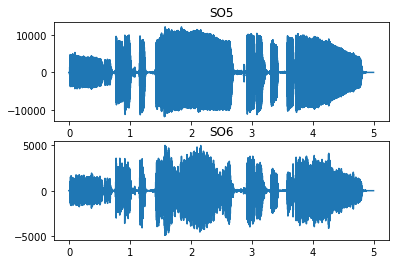

In [228]:
RS1=RecSon(SO1)
RS2=RecSon(SO2)
RS3=RecSon(SO3)
RS4=RecSon(SO4)
RS5=RecSon(SO5)
RS6=RecSon(SO6)

t=np.linspace(0,len(RS1)/V1[0],len(RS1))

f, axarr = plt.subplots(2)
axarr[0].plot(t,RS1)
axarr[0].set_title("SO1")
axarr[1].plot(t,RS2)
axarr[1].set_title("SO2")
plt.show()
f2, axarr2 = plt.subplots(2)
axarr2[0].plot(t,RS3)
axarr2[0].set_title("SO3")
axarr2[1].plot(t,RS4)
axarr2[1].set_title("SO4")
plt.show()
f3, axarr3 = plt.subplots(2)
axarr3[0].plot(t,RS5)
axarr3[0].set_title("SO5")
axarr3[1].plot(t,RS6)
axarr3[1].set_title("SO6")
plt.show()

## Estimation des coeffients de mélange

On suppose dans cette partie qu'on veut effectuer la séparation précédente, sans connaitre les coefficienst de mélange. On parle de séparation aveugle. On va donc chercher à estimer ces coefficients de mélange, ou plus précisément des rapports d'intensité des deux voix pour chacun des instruments. L'idée générale est simple : on va calculer un histogramme des rapports d'intensité des modules des TFCT et sélectionner les 3 valeurs les plus réprésentées dans l'histogramme, c'est à dire les troix maxima locaux de l'histogramme. Dans le détail on procéder de la manière suivante :

1) On construit un tableau ModuleCarre qui va contenir la somme des carrés des modules des TFCT des deux voix.

2) On seuille ce tableau de manière à ne conserver que les N= 10% de coefficients les plus importants du tableau.

3) On construit une matrice $2\times N$ qui contient les pairs d'intensité associées des TFCT des deux voix.

4) On affiche sur un diagramme 2D les points obtnus (on ne les relie pas, on affiche par exemple des croix).

Les points obtenus doivent se répartir approximativement selon des nuages dirigés le long de droites dont les coefficients directeurs sont les rapports d'intensité.

5) On calcule un vecteur $R$ de rapports d'intensité (de longueur N).

6) On affiche un histogramme de $R$ et un histogramme de $U=\frac{R}{1+R}$. Vous devriez observer que les maxima de l'histogramme de $U$ sont plus marqués. 

7) Ecrire un programme qui estime les 3 valeurs des maximas de l'histogramme de U et donc les rapports $R_1$, $R_2$ et $R_3$ associés aux trois isntruments.

8) A l'aide du programme précédent, calculer les seuils optimaux et effectuer la séparation.

9) Commenter.